<a href="https://colab.research.google.com/github/Alxavl/Practice/blob/main/notebooks/Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install libraries
!pip install ts-rnn sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.7/36.7 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 7.6 MB/s eta 0:00:00


In [18]:
#################################           Load libs                      #############################################
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sktime.transformations.series.detrend import Deseasonalizer
%matplotlib inline

from ts_rnn.model import TS_RNN
from keras_tuner import HyperParameters
from ts_rnn.utils import metrics_eval, train_test_pred_plot

## Univariate prediction

In [19]:
TEST_LEN = 55

# Import targets
data_url = "https://raw.githubusercontent.com/Alxavl/Practice/refs/heads/main/series_g.csv"
target = pd.read_csv(data_url, sep=";").series_g
target_train, target_test = train_test_split(target, test_size=TEST_LEN, shuffle=False)

In [20]:
# Deseason target
deseason_transformer = Deseasonalizer(sp=6, model='additive')
target_train_deseas = deseason_transformer.fit_transform(target_train)
target_test_deseas = deseason_transformer.transform(target_test)

# Scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_train_std = pd.Series(target_scaler.fit_transform(target_train_deseas.values.reshape(-1, 1)).flatten(), index=target_train.index, name=target.name)
target_test_std = pd.Series(target_scaler.transform(target_test_deseas.values.reshape(-1, 1)).flatten(), index=target_test.index, name=target.name)

In [21]:
# Create folder for reports
if "reports" not in os.listdir('..'):
    os.makedirs("../reports")
new_folder_num = str(len(os.listdir('../reports')) + 1)
new_folder = os.path.join("../reports", new_folder_num)
os.mkdir(new_folder)
print(f"Save experimnet in {new_folder}")

hp = HyperParameters()
rnn_arch = {"layers": [
                        ["LSTM", {"units": hp.Int(name='units',
                                                 min_value=32,
                                                 max_value=128,
                                                 step=32,
                                                 default=64
                                                ),
                                  "return_sequences": False,
                                  "kernel_initializer": "glorot_uniform",
                                  "activation": hp.Choice(name='LSTM_1_activation',
                                                          values=['relu', 'tanh', 'sigmoid', "linear"],
                                                          default='relu'),
                                  }],
                        ["Dropout", {"rate": hp.Float(name='dropout',
                                                      min_value=0.0,
                                                      max_value=0.5,
                                                      default=0.2,
                                                      step=0.05)
                                     }],
                        ["Dense", {"activation": "linear"}]
                    ]}

model = TS_RNN(rnn_arch=rnn_arch,
               n_lags=52,
               horizon=TEST_LEN,
               tuner_hp=hp,
               tuner="BayesianOptimization", #"RandomSearch", "BayesianOptimization", "Hyperband"
               strategy="MiMo", #"Direct", "Recursive", "MiMo", "DirRec", "DirMo"
               max_trials=3,
               save_dir=new_folder,
               loss="mae",
               optimizer="adam"
               )

Save experimnet in ../reports/4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.fit(target_train=target_train_std,
          target_val=target_test_std,
          epochs=265,
          batch_size=12,
          verbose=1)

model.summary()

Trial 3 Complete [00h 02m 25s]
val_loss: 0.08270183950662613

Best val_loss So Far: 0.08270183950662613
Total elapsed time: 00h 07m 16s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
INFO:ts_rnn_logger:[Training] Training ended
INFO:ts_rnn_logger:[Timing] fit takes: 437.27 sec


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 55)                  │           3,575 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,471 (79.96 KB)

 Trainable params: 20,471 (79.96 KB)

 Non-trainable params: 0 (0.00 B)

INFO:ts_rnn_logger:[Prediction] Start predict by MiMo strategy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


INFO:ts_rnn_logger:[Prediction] End predict by MiMo strategy
INFO:ts_rnn_logger:[Timing] predict takes: 0.42 sec


Mean Absolute Error: 11.072
Mean Squared Error: 405.984
Symmetric Mean absolute percentage error: 23.262
Root Mean Squared Error: 20.149
Mean absolute percentage error: 87.034


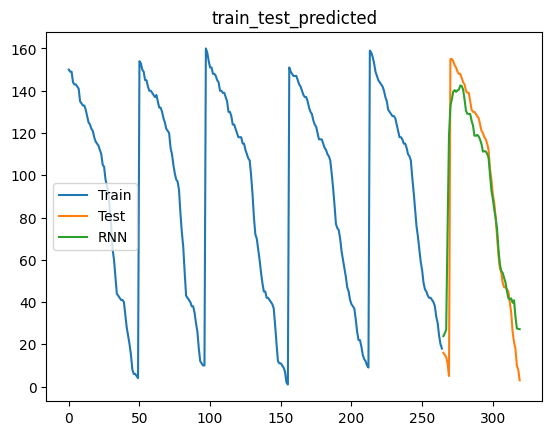

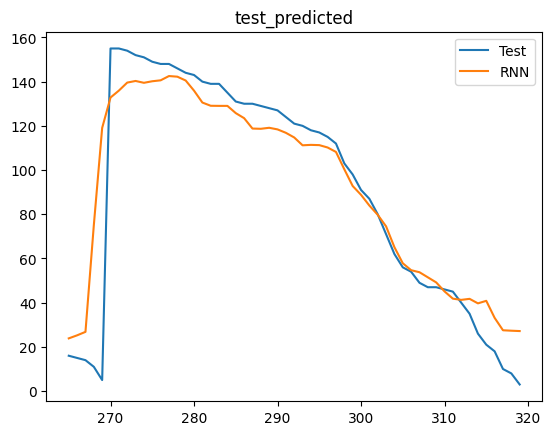

In [23]:
predicted_std = model.predict(target=target_train_std[-model.n_lags:], prediction_len=TEST_LEN)

# inverse transform
predicted_rnn = target_scaler.inverse_transform(predicted_std.reshape(-1, 1)).flatten()
predicted_rnn = pd.Series(predicted_rnn,index=target_test.index)
predicted_rnn = deseason_transformer.inverse_transform(predicted_rnn)

metrics_eval(target_test[:len(predicted_rnn)], predicted_rnn, print_result=True, save_dir=new_folder)
predicted = {"RNN": {"predictions": predicted_rnn}}

train_test_pred_plot(train=target_train, test=target_test, predicted=predicted,
                     save_dir=new_folder, show=True);

## Mulrivariate prediction (Target + Factors)

In [ ]:
# Import targets
data_url = "https://raw.githubusercontent.com/LevPerla/Time_Series_Prediction_RNN/master/data/series_g.csv"
target = pd.read_csv(data_url, sep=";").series_g

# Generate factors
f1 = np.arange(1, len(target) + 1).reshape(-1, 1)
f2 = (np.arange(1, len(target) + 1) ** 2).reshape(-1, 1)
factors = pd.DataFrame(np.hstack((f1, f2)))

factors_train, factors_test, target_train, target_test = train_test_split(factors,
                                                                          target,
                                                                          test_size=TEST_LEN,
                                                                          random_state=42,
                                                                          shuffle=False)

In [ ]:
# Deseason target
deseason_transformer = Deseasonalizer(sp=12, model='multiplicative')
target_train_deseas = deseason_transformer.fit_transform(target_train)
target_test_deseas = deseason_transformer.transform(target_test)

# Scale target
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_train_std = pd.Series(target_scaler.fit_transform(target_train_deseas.values.reshape(-1, 1)).flatten(), index=target_train.index, name=target.name)
target_test_std = pd.Series(target_scaler.transform(target_test_deseas.values.reshape(-1, 1)).flatten(), index=target_test.index, name=target.name)

#scale factors
factors_scaler = MinMaxScaler(feature_range=(0, 1))
factors_train_std = pd.DataFrame(factors_scaler.fit_transform(factors_train), index=factors_train.index, columns=factors_train.columns)
factors_test_std = pd.DataFrame(factors_scaler.transform(factors_test), index=factors_test.index, columns=factors_test.columns)

In [ ]:
model = TS_RNN(rnn_arch=rnn_arch,
               n_lags=12,
               horizon=TEST_LEN,
               tuner_hp=hp,
               tuner="BayesianOptimization", #"RandomSearch", "BayesianOptimization", "Hyperband"
               strategy="MiMo", #"Direct", "Recursive", "MiMo", "DirRec", "DirMo"
               max_trials=3,
               save_dir=new_folder,
               loss="mae",
               optimizer="adam",
               n_features=factors_train_std.shape[1]  # also you need to define this if use factors
               )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Create folder for reports
if "reports" not in os.listdir('..'):
    os.makedirs("../reports")
new_folder_num = str(len(os.listdir('../reports')) + 1)
new_folder = os.path.join("../reports", new_folder_num)
os.mkdir(new_folder)
print(f"Save experimnet in {new_folder}")

model.fit(factors_train=factors_train_std,  # also you need to define this if use factors
          target_train=target_train_std,
          factors_val=factors_test_std,
          target_val=target_test_std,
          epochs=30,
          batch_size=12,
          verbose=1)

model.summary()

Trial 3 Complete [00h 00m 08s]
val_loss: 0.04339151456952095

Best val_loss So Far: 0.04108482971787453
Total elapsed time: 00h 00m 23s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
INFO:ts_rnn_logger:[Training] Training ended
INFO:ts_rnn_logger:[Timing] fit takes: 23.49 sec


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,188 (71.05 KB)

 Trainable params: 18,188 (71.05 KB)

 Non-trainable params: 0 (0.00 B)

INFO:ts_rnn_logger:[Prediction] Start predict by MiMo strategy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


INFO:ts_rnn_logger:[Prediction] End predict by MiMo strategy
INFO:ts_rnn_logger:[Timing] predict takes: 0.22 sec


Mean Absolute Error: 13.62
Mean Squared Error: 378.38
Symmetric Mean absolute percentage error: 2.893
Root Mean Squared Error: 19.452
Mean absolute percentage error: 2.948


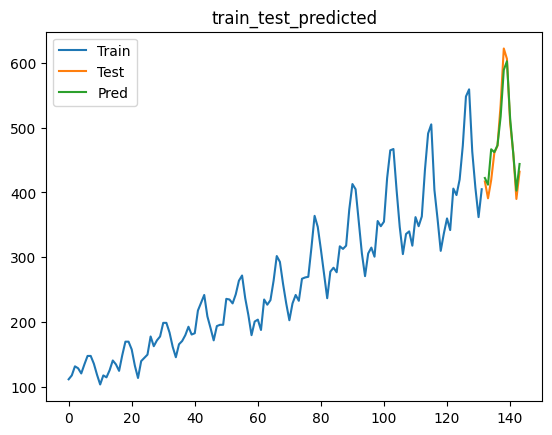

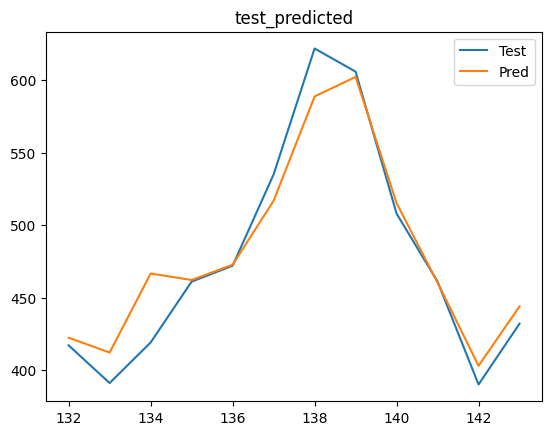

In [ ]:
predicted_std = model.predict(
    factors=factors_train_std[-model.n_lags:],  # also you need to define this if use factors
    target=target_train_std[-model.n_lags:],
    prediction_len=TEST_LEN
)

# inverse transform
predicted_rnn = target_scaler.inverse_transform(predicted_std.reshape(-1, 1)).flatten()
predicted_rnn = pd.Series(predicted_rnn,index=target_test.index)
predicted_rnn = deseason_transformer.inverse_transform(predicted_rnn)

metrics_eval(target_test[:len(predicted_rnn)], predicted_rnn, print_result=True, save_dir=new_folder)
train_test_pred_plot(train=target_train, test=target_test, predicted=predicted_rnn, save_dir=new_folder);